# Ridge & Lasso Regression

We will be using a small dataset to predict the target variable using basic linear regression, ridge regression and Lasso. We import the library functions we need and disactivate the warnings.

In [1]:
# import all the required libraries and put matplotlib in inline mode to plot on the notebook
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn import model_selection
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV

from sklearn.preprocessing import PolynomialFeatures
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

saved_figsize = plt.rcParams['figure.figsize']

We generate the datapoints using a simple sinus and plot the data.

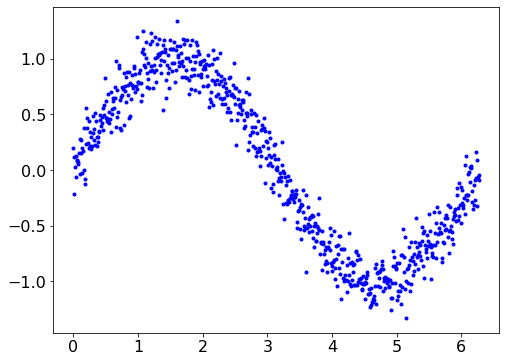

In [2]:
X = np.array([i*np.pi/180 for i in np.arange(0,360,.5)]).reshape(-1,1)

np.random.seed(10)  #Setting seed for reproducability

y = np.sin(X)+np.random.normal(0,0.15,len(X)).reshape(-1,1)

# dataset = pd.DataFrame({'x':X, 'y':y})

##
## Split train and test
##

plt.rcParams['figure.figsize'] = (8.0, 6.0)
font = {'family' : 'sans', 'size'   : 16}
plt.rc('font', **font)
plt.plot(X,y,'.', color='blue');

## We are going to use polynomials of at most degree 12
max_polynomial=12

We define the usual utility functions to plot the resulting approximation.

In [3]:
def plot_scatter(x,y,xp,yp,title=""):
    """Plots the original data (x,y) and a set of point (xp,yp) showing the model approximation"""
    font = {'family' : 'sans',
        'size'   : 14}
    plt.rc('font', **font)

    plt.scatter(x, y,  color='blue')
    plt.plot(xp, yp, color='red', linewidth=3)
    plt.xlabel("x")
    plt.ylabel("y")
    
    if (title!=""):
        plt.title(title)

    plt.show()

In [4]:
def ApplyRegression(regressor,evaluation='crossvalidation',do_plot=True):
    max_polynomial = 12
    
    if (do_plot):
        f, axarr = plt.subplots(3, 4)   
        plt.rcParams['figure.figsize'] = (40.0, 20.0)
        font = {'family' : 'sans', 'size'   : 16}
        plt.rc('font', **font)

    r2_values = []
    max_coefficients = []

    for degree in range(1,max_polynomial+1):
        if (degree!=1):
            polynomial = PolynomialFeatures(degree=degree, include_bias=False)
            X_polynomial = polynomial.fit_transform(X)
            Xplot = np.arange(np.min(X),np.max(X),0.1).reshape(-1,1)
            Xplot_polynomial = polynomial.fit_transform(Xplot)
        else:
            Xplot = np.arange(np.min(X),np.max(X),0.1).reshape(-1,1)
            Xplot_polynomial = Xplot
            X_polynomial = X
        
        if (evaluation=='crossvalidation'):
            
            # apply crossvalidation
            score = cross_val_score(regressor, X_polynomial, y, cv=KFold(n_splits=10, shuffle=True, random_state=1234))        

            # score the model
            r2 = score.mean()
            r2_values.append(np.mean(score))

            # create the model on the entire data
            regressor.fit(X_polynomial, y);

            max_coefficients.append(np.amax(np.abs(regressor.coef_)))

            # compute the model on the plotted poins
            yplot = regressor.predict(Xplot_polynomial)
        elif (evaluation=='holdout'):

            X_train, X_test, y_train, y_test = model_selection.train_test_split(X_polynomial, y, test_size=0.33, random_state=1234)
            
            regressor.fit(X_train, y_train);
            
            max_coefficients.append(np.amax(np.abs(regressor.coef_)))
            
            # score the model
            yp = regressor.predict(X_test)
            r2 = r2_score(y_test, yp)
            r2_values.append(r2)
            
        elif (evaluation=='train'):

            # create the model on the entire data
            regressor.fit(X_polynomial, y);
            
            #evaluation on the train
            yp = regressor.predict(X_polynomial)
            r2 = r2_score(y, yp)
            r2_values.append(r2)

            max_coefficients.append(np.amax(np.abs(regressor.coef_)))
        else:
            raise Exception('evaluation valid values:\n- crossvalidation\n- holdout\n- train')
            
        # compute the model on the plotted poins
        yplot = regressor.predict(Xplot_polynomial)

        if (do_plot):
            target_plot = axarr[int((degree-1)/4),int((degree-1)%4)]
            target_plot.scatter(X[:,0],y, color="blue")
            target_plot.set_title("Degree = %d $R^2$=%.3f"%(degree,r2))
            target_plot.plot(Xplot[:,0],yplot, color="red",linewidth=3)
        
    return r2_values, max_coefficients, regressor.coef_

Let's plot various approximations using different polynomials, different regression methods and crossvalidation.

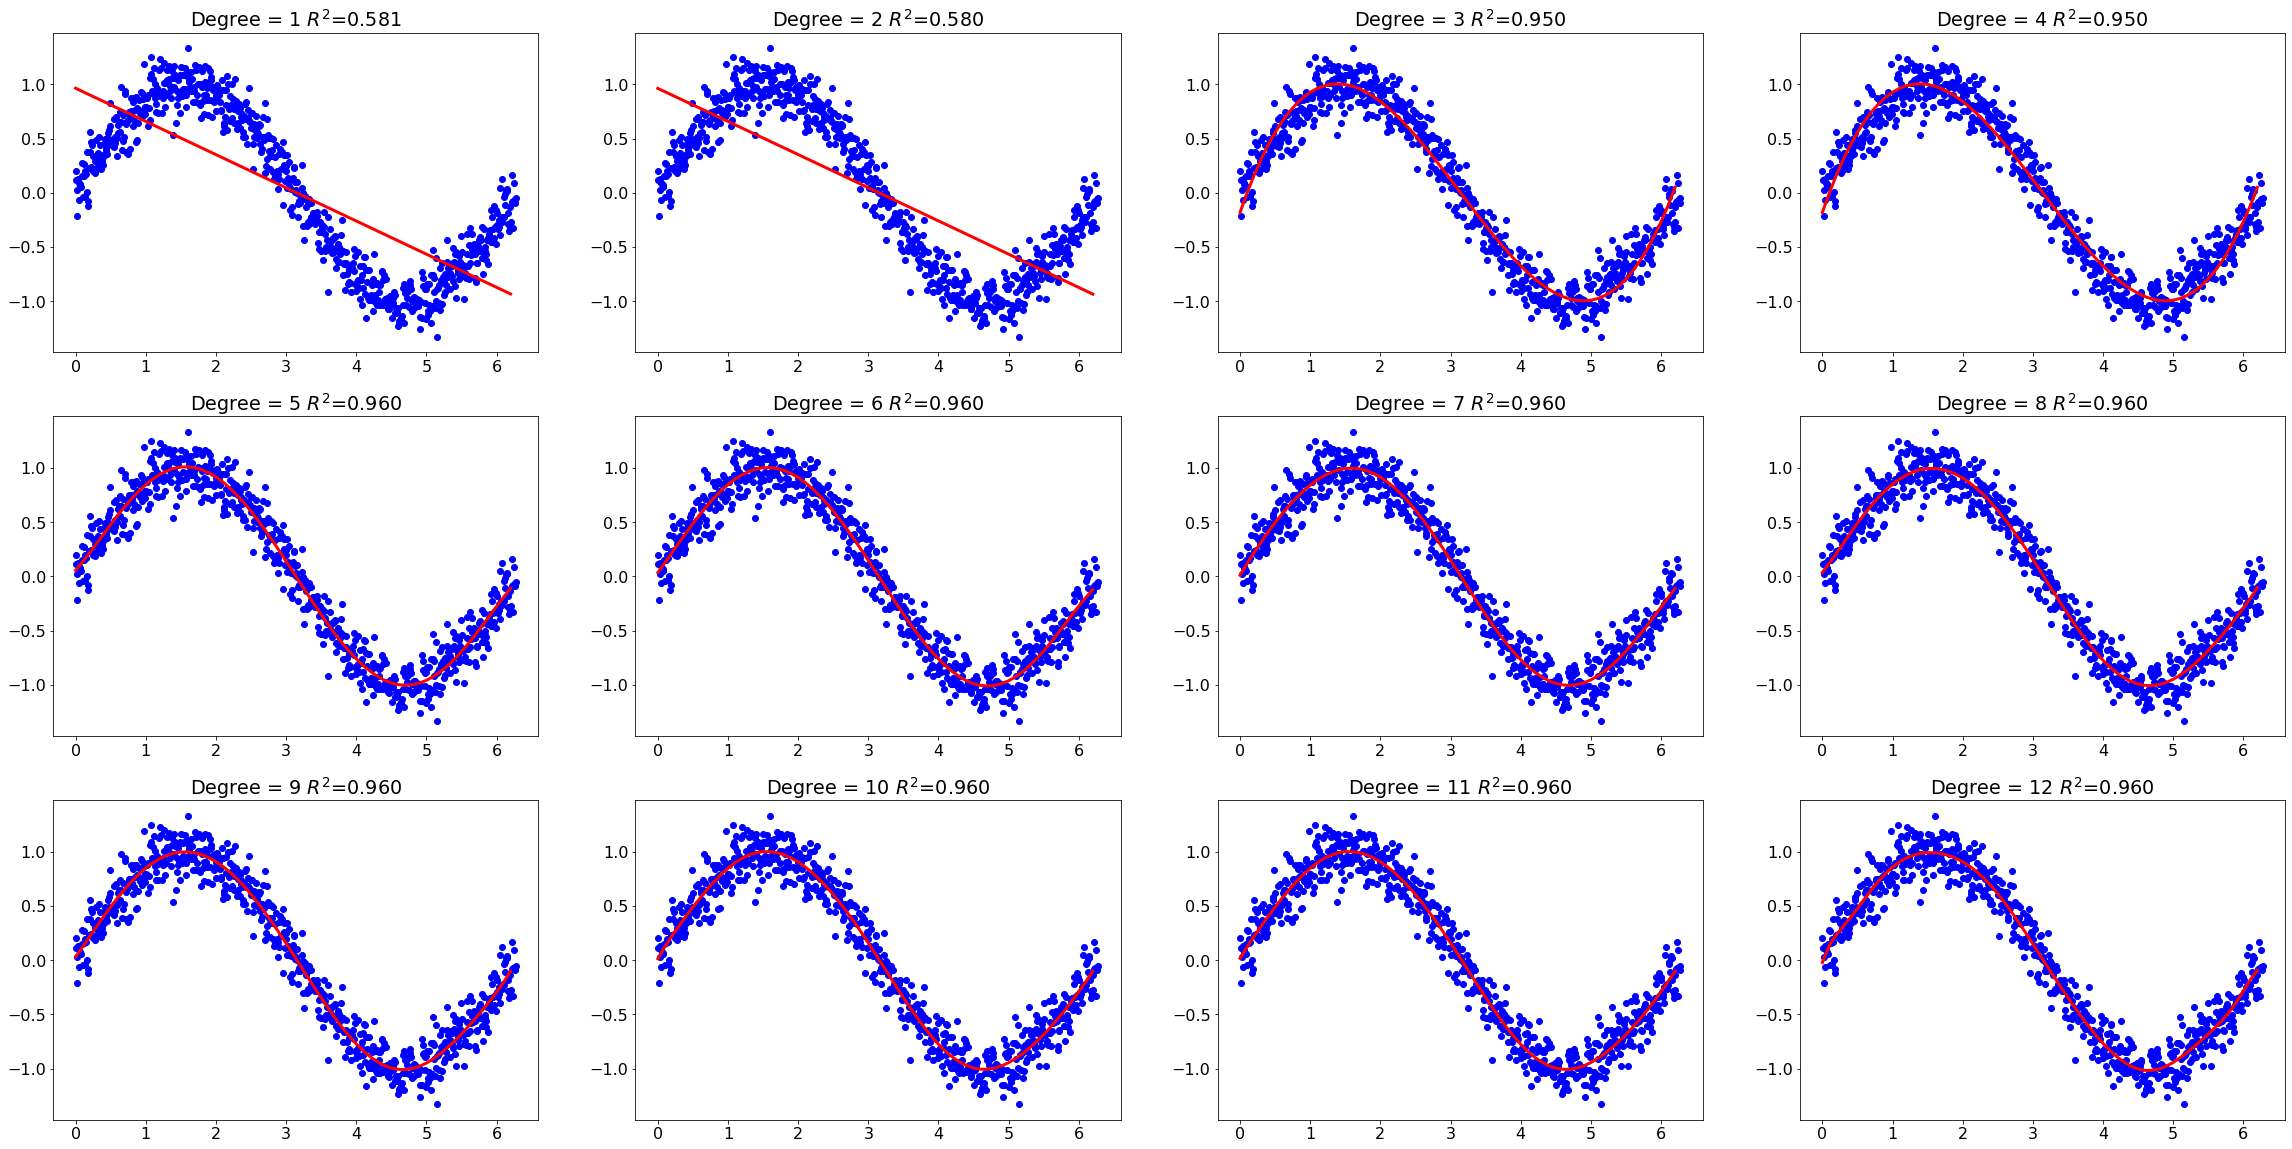

In [6]:
r2_values, max_coefficients, weights = ApplyRegression(LinearRegression(),'crossvalidation')

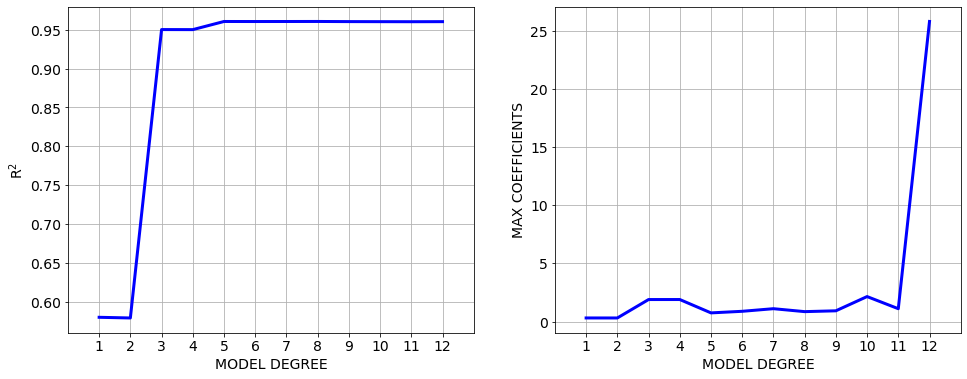

In [10]:
plt.rcParams['figure.figsize'] = (16.0, 6.0)
font = {'family' : 'sans', 'size':14}
plt.rc('font', **font)
f, axarr = plt.subplots(1, 2)

axarr[0].set_xlabel("MODEL DEGREE")
axarr[0].set_ylabel("R$^2$")
axarr[0].set_xlim([0,13])
axarr[0].set_xticks(range(1,13))
axarr[0].grid()
axarr[0].plot(range(1,13), r2_values, color="blue",linewidth=3);

axarr[1].set_xlabel("MODEL DEGREE")
axarr[1].set_ylabel("MAX COEFFICIENTS")
axarr[1].set_xlim([0,13])
axarr[1].set_xticks(range(1,13))
axarr[1].grid()
axarr[1].plot(range(1,13), max_coefficients, color="blue",linewidth=3);

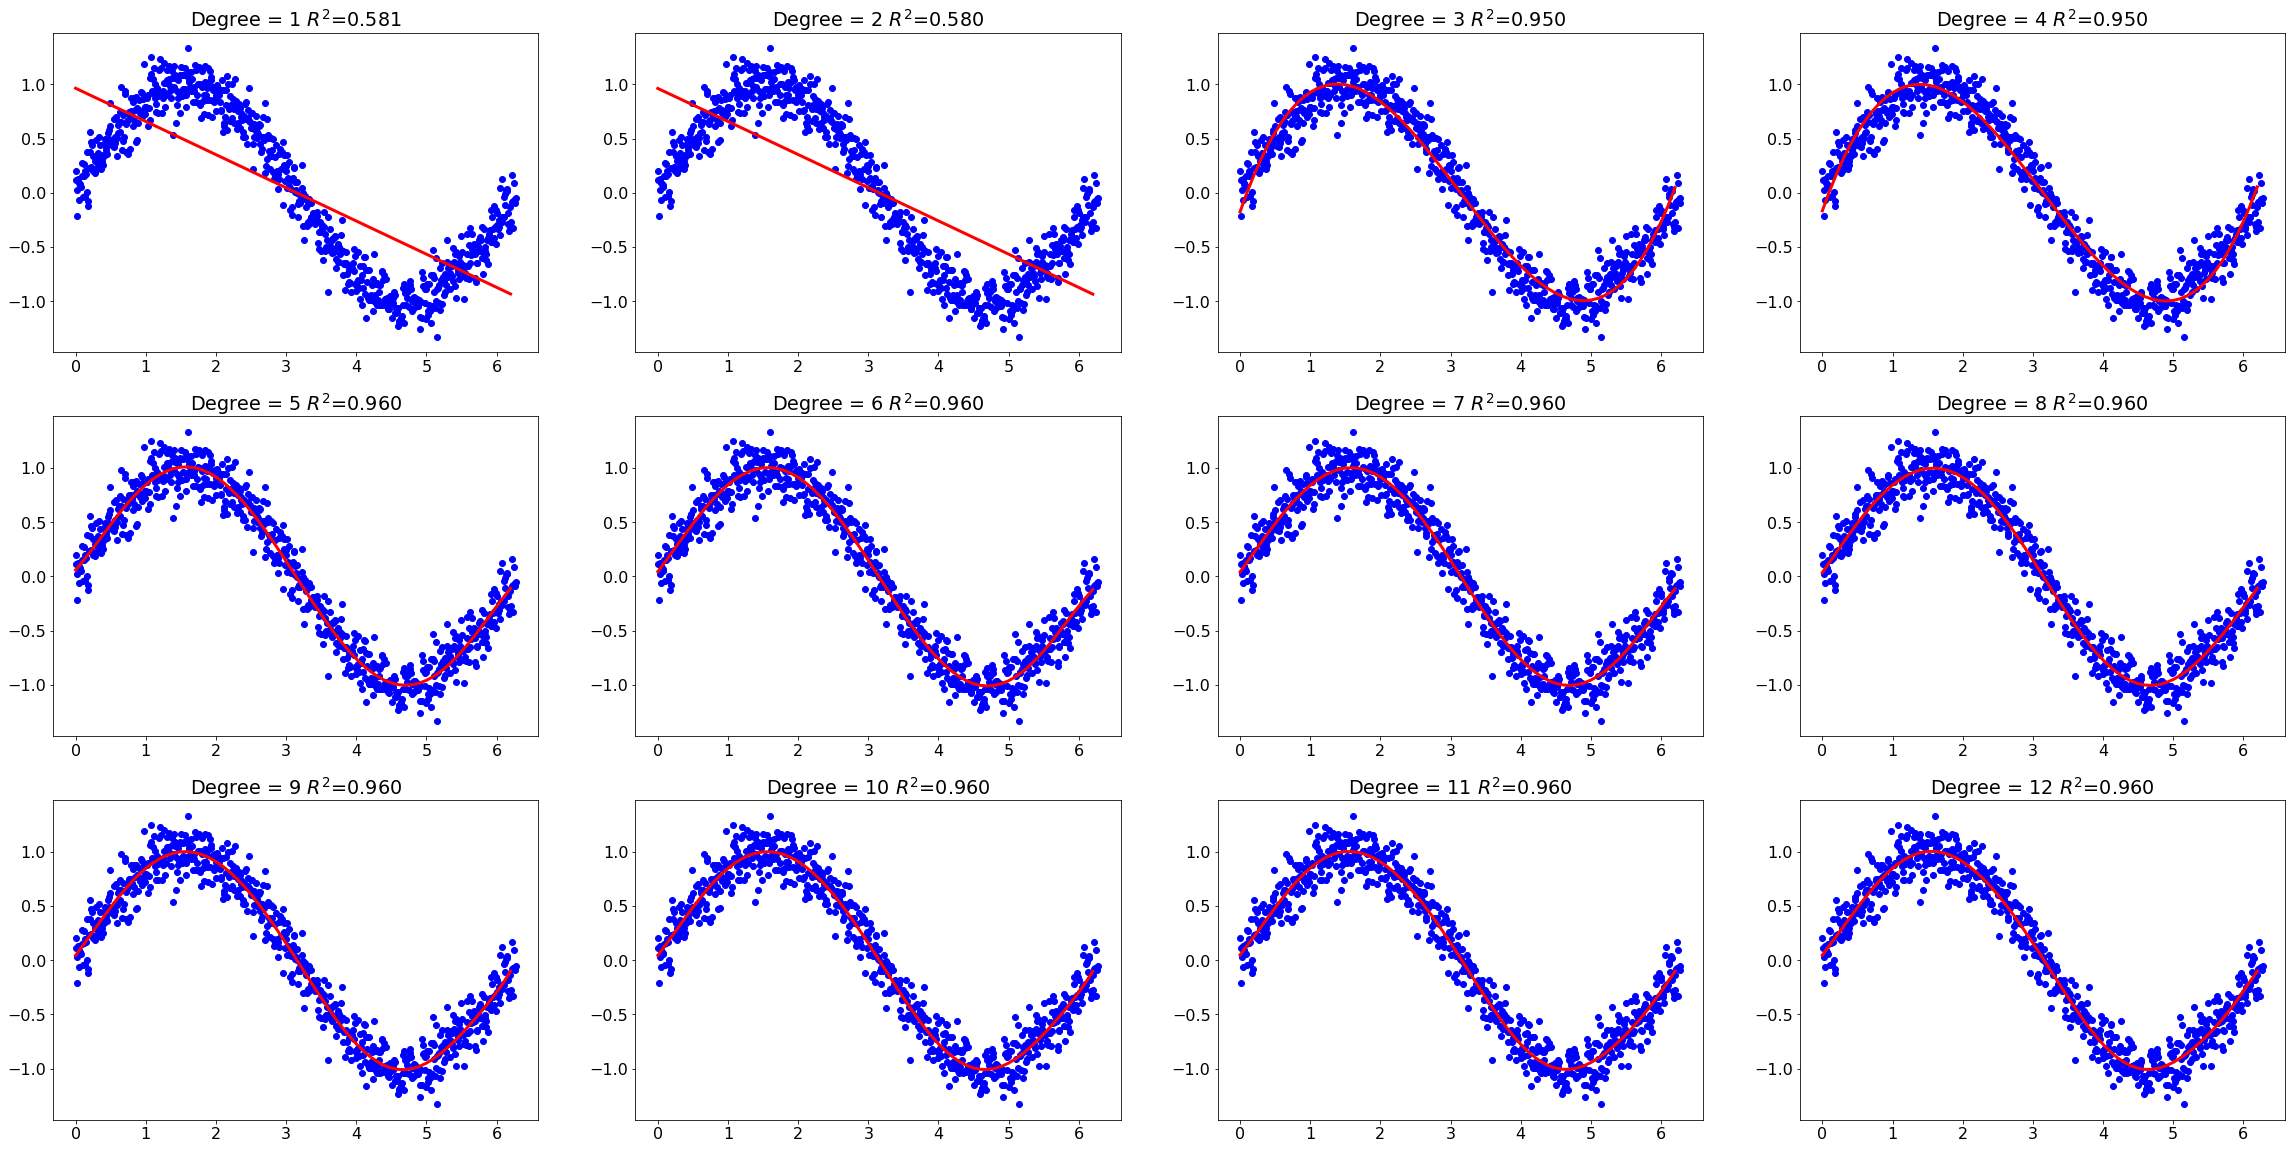

In [21]:
r2_values, max_coefficients, weights = ApplyRegression(Ridge(alpha=0.1,random_state=1234),'crossvalidation')

Let's plot the largest absolute weight value in each run.

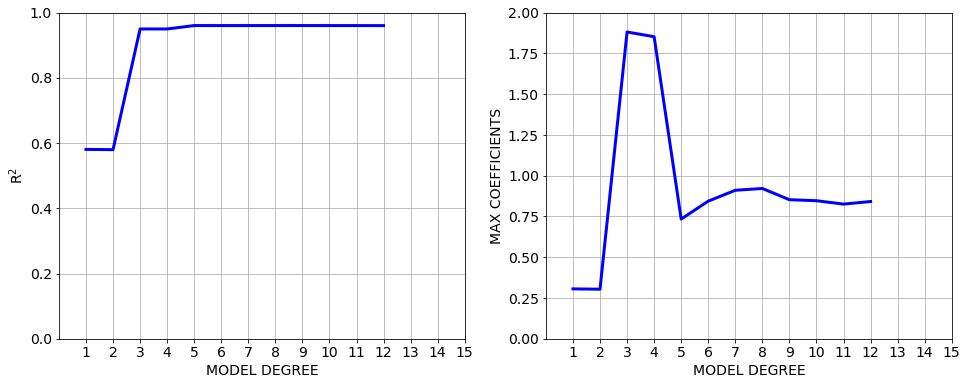

In [22]:
plt.rcParams['figure.figsize'] = (16.0, 6.0)
font = {'family' : 'sans', 'size':14}
plt.rc('font', **font)
f, axarr = plt.subplots(1, 2)

axarr[0].set_xlabel("MODEL DEGREE")
axarr[0].set_ylabel("R$^2$")
axarr[0].set_xlim([0,13])
axarr[0].set_ylim([0,1])
axarr[0].set_xticks(range(1,16))
axarr[0].grid()
axarr[0].plot(range(1,13), r2_values, color="blue",linewidth=3);

axarr[1].set_xlabel("MODEL DEGREE")
axarr[1].set_ylabel("MAX COEFFICIENTS")
axarr[1].set_xlim([0,13])
axarr[1].set_ylim([0,2])
axarr[1].set_xticks(range(1,16))
axarr[1].grid()
axarr[1].plot(range(1,13), max_coefficients, color="blue",linewidth=3);

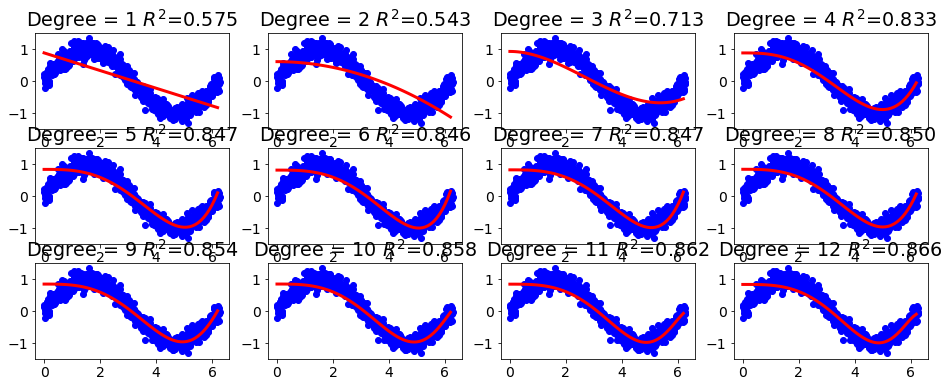

In [23]:
r2_values, max_coefficients, weights = ApplyRegression(Lasso(alpha=0.1, random_state=1234),'crossvalidation')

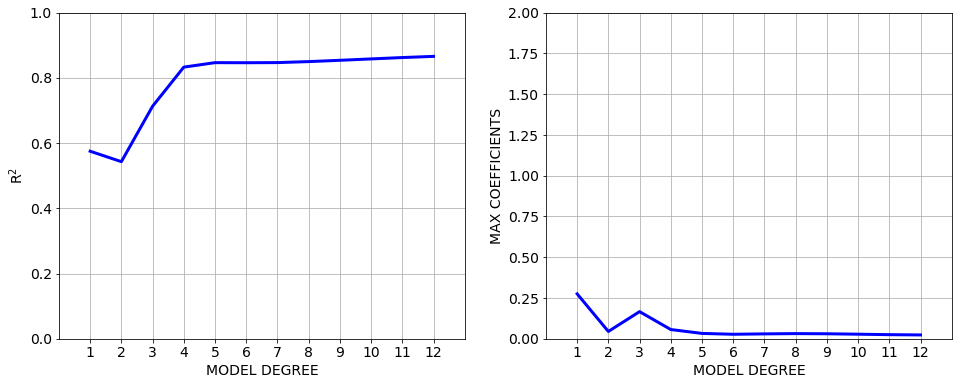

In [24]:
plt.rcParams['figure.figsize'] = (16.0, 6.0)
font = {'family' : 'sans', 'size':14}
plt.rc('font', **font)
f, axarr = plt.subplots(1, 2)

axarr[0].set_xlabel("MODEL DEGREE")
axarr[0].set_ylabel("R$^2$")
axarr[0].set_xlim([0,13])
axarr[0].set_ylim([0,1])
axarr[0].set_xticks(range(1,13))
axarr[0].grid()
axarr[0].plot(range(1,13), r2_values, color="blue",linewidth=3);

axarr[1].set_xlabel("MODEL DEGREE")
axarr[1].set_ylabel("MAX COEFFICIENTS")
axarr[1].set_xlim([0,13])
axarr[1].set_ylim([0,2])
axarr[1].set_xticks(range(1,13))
axarr[1].grid()
axarr[1].plot(range(1,13), max_coefficients, color="blue",linewidth=3);

## The Effect of $\alpha$ on the Weights
Let's see how the final weights vary based on the value of $\alpha$.


In [41]:
set_of_alphas = [0.01, 0.05, 0.1, 0.5, 1, 5, 10, 15, 20, 40]
degree = 5

ridge_weights = []
lasso_weights = []

for alpha in set_of_alphas:
#     xm, ym, yp, rss, r2, regr = compute_polynomial_ridge(dataset,'x', 'y', 10, a=alpha)
    # create the model on the entire data
    polynomial = PolynomialFeatures(degree=degree, include_bias=False)
    X_polynomial = polynomial.fit_transform(X)

    ridge = Ridge(alpha=alpha, random_state=1234, max_iter=10000)    
    ridge.fit(X_polynomial, y)
    ridge_weights.append(ridge.coef_[0])

    lasso = Lasso(alpha=alpha, random_state=1234)
    lasso.fit(X_polynomial, y)
    lasso_weights.append(lasso.coef_)
                   

In [42]:
ridge_matrix = pd.DataFrame(data=ridge_weights)
ridge_matrix.columns = ['w'+str(i) for i in range(degree)]

lasso_matrix = pd.DataFrame(data=lasso_weights)
lasso_matrix.columns = ['w'+str(i) for i in range(degree)]

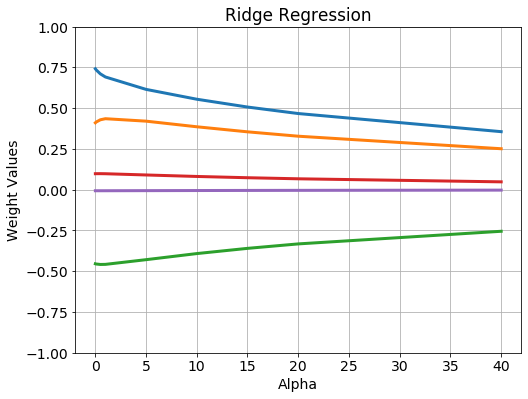

In [43]:
font = {'family' : 'sans', 'size'   : 14}
plt.rc('font', **font)
plt.rcParams['figure.figsize'] = (8.0, 6.0)

for i in range(degree):
    plt.plot(set_of_alphas, ridge_matrix['w'+str(i)], linewidth=3)
    
plt.ylim([-1,1])
plt.xlabel('Alpha')
plt.ylabel('Weight Values')
plt.title("Ridge Regression")
plt.grid()

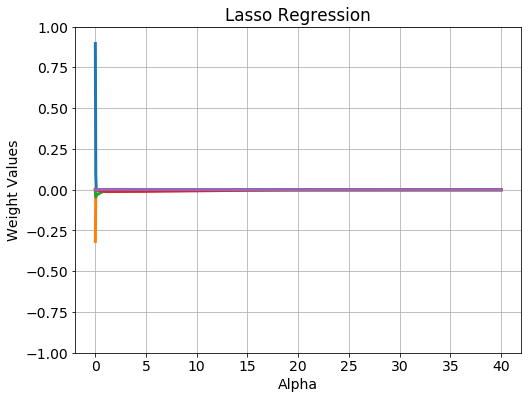

In [44]:
font = {'family' : 'sans', 'size'   : 14}
plt.rc('font', **font)
plt.rcParams['figure.figsize'] = (8.0, 6.0)

for i in range(degree):
    plt.plot(set_of_alphas, lasso_matrix['w'+str(i)], linewidth=3)
    
plt.ylim([-1,1])
plt.xlabel('Alpha')
plt.ylabel('Weight Values')
plt.title("Lasso Regression")
plt.grid()

## Selecting the Regularization Coefficient $\alpha$
When applying regularization we need to select the value of $\alpha$ which works as a hyperparameter. For this purpose, we cannot just run different regression using the entire data set with different values of $\alpha$ but we need to evaluate each $\alpha$ by applying either holdout evaluation or crossover evaluation on a training set; then, once we selected the alpha, we can evaluate the value over the test set. Note that, by applying holdout on the training set we generate two sets, the training set and the validation set (sometimes called the dev or development set). In the following example, we apply RidgeCV and LassoCV, two procedures available in Scikit-Learn that perform crossvalidation to compute the best value of $\alpha$. 

In [45]:
def ApplyRegularizedCVRegression(regressor, do_plot=True):
    max_polynomial = 8
    
    if not isinstance(regressor, RidgeCV) and not isinstance(regressor, LassoCV):
        raise Exception('Works with RidgeCV or LassoCV')

    if (do_plot):
        f, axarr = plt.subplots(2, 4)   
        plt.rcParams['figure.figsize'] = (40.0, 10.0)
        font = {'family' : 'sans', 'size'   : 16}
        plt.rc('font', **font)

    r2_values = []
    max_coefficients = []
    computed_alphas = []

    for degree in range(1,max_polynomial+1):
        if (degree!=1):
            polynomial = PolynomialFeatures(degree=degree, include_bias=False)
            X_polynomial = polynomial.fit_transform(X)
            Xplot = np.arange(np.min(X),np.max(X),0.1).reshape(-1,1)
            Xplot_polynomial = polynomial.fit_transform(Xplot)
        else:
            Xplot = np.arange(np.min(X),np.max(X),0.1).reshape(-1,1)
            Xplot_polynomial = Xplot
            X_polynomial = X
        
        X_train, X_test, y_train, y_test = model_selection.train_test_split(X_polynomial, y, test_size=0.33, random_state=1234)

        clf = regressor.fit(X_train, y_train)

        max_coefficients.append(np.amax(np.abs(regressor.coef_)))

        yp = regressor.predict(X_test)            
        r2 = r2_score(y_test, yp)
        r2_values.append(r2)

        computed_alphas.append(regressor.alpha_)
            
        # compute the model on the plotted poins
        yplot = regressor.predict(Xplot_polynomial)

        if (do_plot):
            target_plot = axarr[int((degree-1)/4),int((degree-1)%4)]
            target_plot.scatter(X[:,0],y, color="blue")
            target_plot.set_title("Degree = %d $R^2$=%.3f"%(degree,r2))
            target_plot.plot(Xplot[:,0],yplot, color="red")
        
    return r2_values, max_coefficients, computed_alphas

First, let's try Ridge regression using crossvalidation to compute, for each polynomial, the best alpha among the ones provided as a parameter.

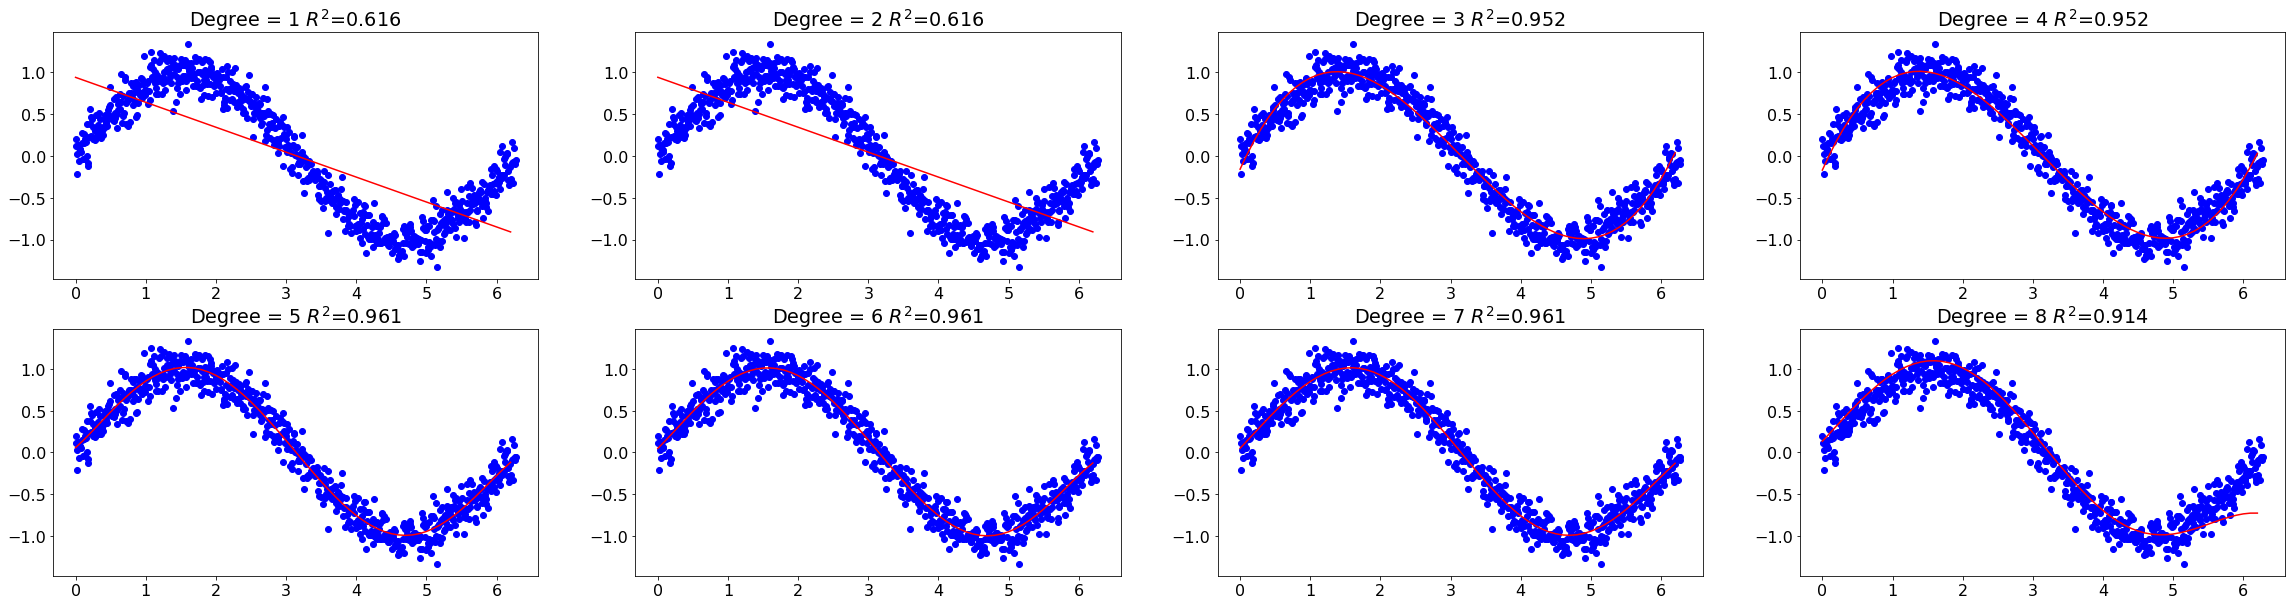

In [48]:
r2_values, max_coefficients, computed_alphas = ApplyRegularizedCVRegression(RidgeCV(alphas=[1e-10,1e-5,1e-4,1e-3, 1e-2, 1e-1, 1]))

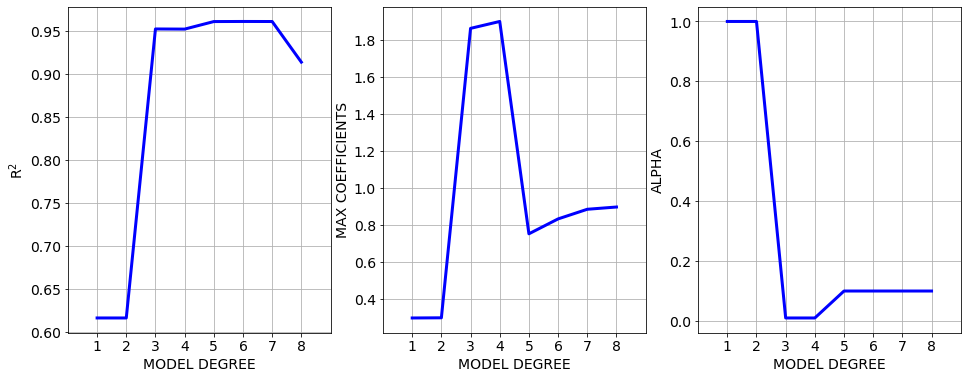

In [49]:
plt.rcParams['figure.figsize'] = (16.0, 6.0)
font = {'family' : 'sans', 'size':14}
plt.rc('font', **font)
f, axarr = plt.subplots(1, 3)

axarr[0].set_xlabel("MODEL DEGREE")
axarr[0].set_ylabel("R$^2$")
axarr[0].set_xlim([0,len(r2_values)+1])
axarr[0].set_xticks(range(1,len(r2_values)+1))
axarr[0].grid()
axarr[0].plot(range(1,len(r2_values)+1), r2_values, color="blue",linewidth=3);

axarr[1].set_xlabel("MODEL DEGREE")
axarr[1].set_ylabel("MAX COEFFICIENTS")
axarr[1].set_xlim([0,len(r2_values)+1])
axarr[1].set_xticks(range(1,len(r2_values)+1))
axarr[1].grid()
axarr[1].plot(range(1,len(r2_values)+1), max_coefficients, color="blue",linewidth=3);

axarr[2].set_xlabel("MODEL DEGREE")
axarr[2].set_ylabel("ALPHA")
axarr[2].set_xlim([0,len(r2_values)+1])
axarr[2].set_xticks(range(1,len(r2_values)+1))
axarr[2].grid()
axarr[2].plot(range(1,len(r2_values)+1), computed_alphas, color="blue",linewidth=3);



Let's repeat everything using Lasso regression.

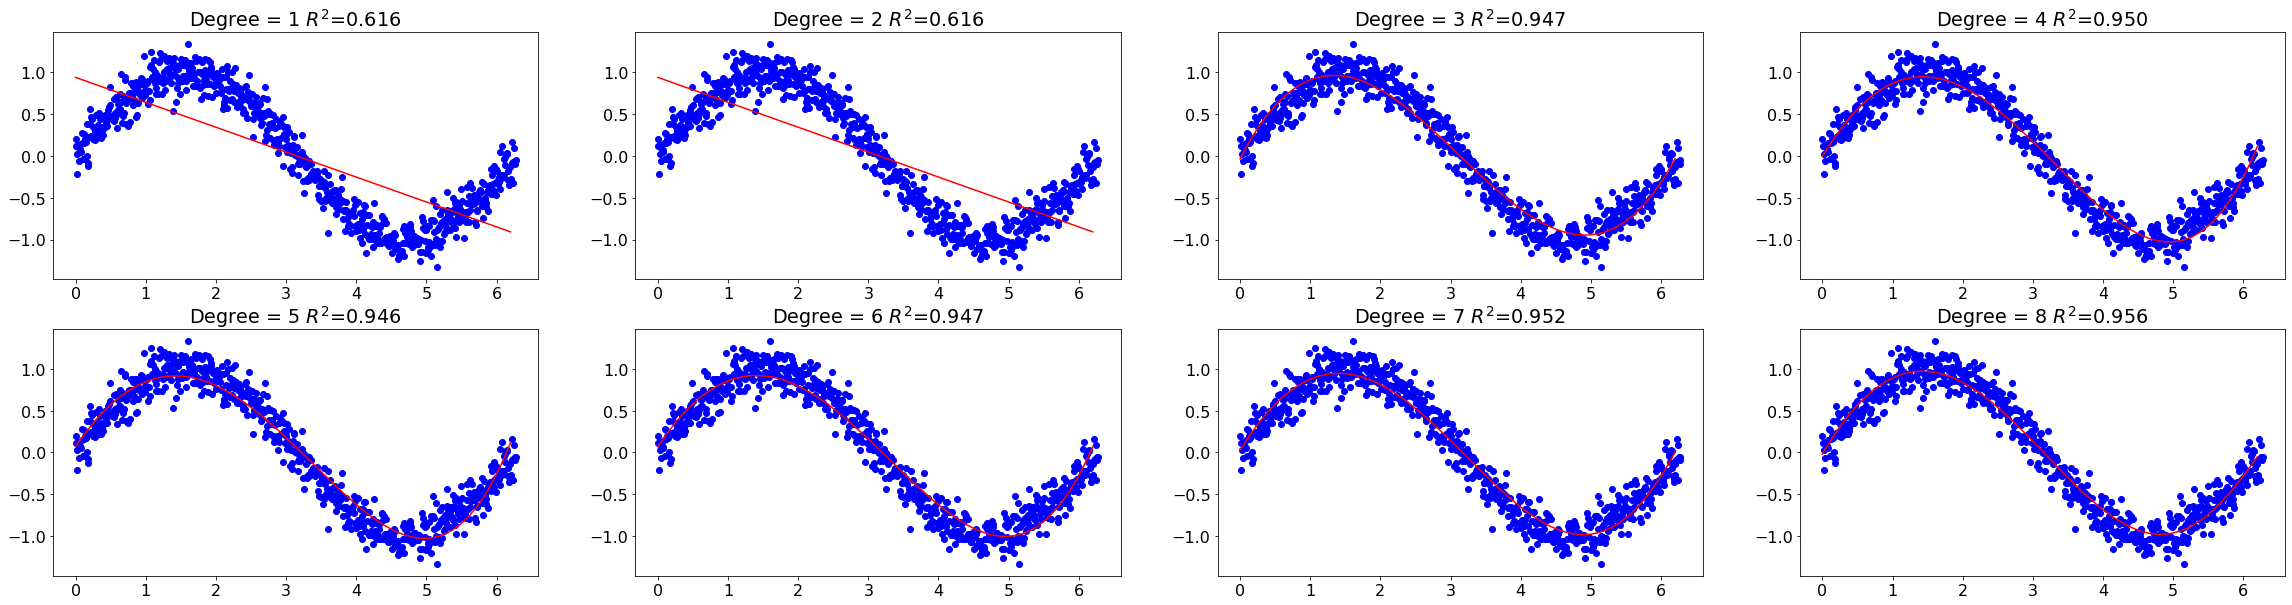

In [51]:
r2_values, max_coefficients, computed_alphas = ApplyRegularizedCVRegression(LassoCV(alphas=[1e-10,1e-5,1e-4,1e-3, 1e-2, 1e-1, 1]))

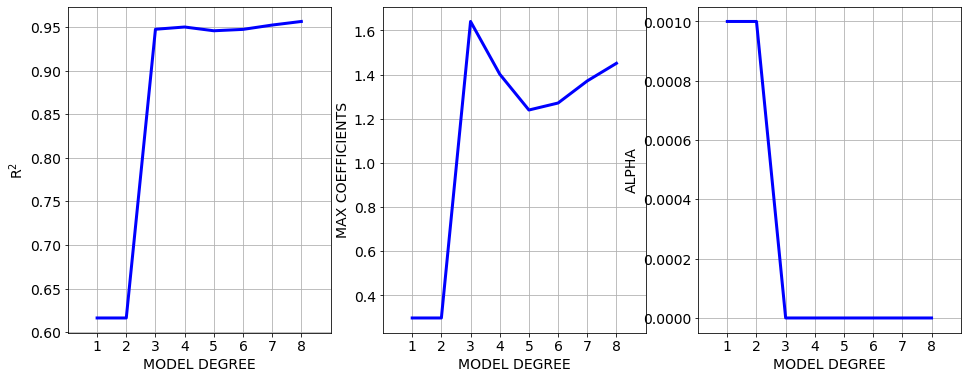

In [52]:
plt.rcParams['figure.figsize'] = (16.0, 6.0)
font = {'family' : 'sans', 'size':14}
plt.rc('font', **font)
f, axarr = plt.subplots(1, 3)

axarr[0].set_xlabel("MODEL DEGREE")
axarr[0].set_ylabel("R$^2$")
axarr[0].set_xlim([0,len(r2_values)+1])
axarr[0].set_xticks(range(1,len(r2_values)+1))
axarr[0].grid()
axarr[0].plot(range(1,len(r2_values)+1), r2_values, color="blue",linewidth=3);

axarr[1].set_xlabel("MODEL DEGREE")
axarr[1].set_ylabel("MAX COEFFICIENTS")
axarr[1].set_xlim([0,len(r2_values)+1])
axarr[1].set_xticks(range(1,len(r2_values)+1))
axarr[1].grid()
axarr[1].plot(range(1,len(r2_values)+1), max_coefficients, color="blue",linewidth=3);

axarr[2].set_xlabel("MODEL DEGREE")
axarr[2].set_ylabel("ALPHA")
axarr[2].set_xlim([0,len(r2_values)+1])
axarr[2].set_xticks(range(1,len(r2_values)+1))
axarr[2].grid()
axarr[2].plot(range(1,len(r2_values)+1), computed_alphas, color="blue",linewidth=3);